<a href="https://colab.research.google.com/github/nbadino/ItaOil/blob/main/oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prima bozza del paper di policy evaluation sui prezzi del carburante dopo che i prezzi medi verranno esposti al di fuori di ogni distributore

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests
from zipfile import ZipFile, BadZipFile
import xml.etree.ElementTree as ET
from io import BytesIO
!pip install geopy reverse_geocoder
import reverse_geocoder as rg
import subprocess

In [23]:
def download_and_extract_data():
    # Check if file exists
    if not os.path.isfile("/content/main.zip"):
        print("File not found, downloading...")
        # Execute wget command
        try:
            subprocess.check_call(['wget', 'https://github.com/nbadino/ItaOil/archive/refs/heads/main.zip', '-P', '/content'])
            print("File downloaded, unzipping...")
            subprocess.check_call(['unzip', "/content/main.zip", '-d', '/content'])
        except subprocess.CalledProcessError as e:
            print("Could not download or unzip file: ", e)
    else:
        print("File exists.")


"""def load_data_from_dir(price_filepath, gas_station_filepath):
    price_files = [f for f in os.listdir(price_filepath) if f.endswith('.csv')]
    gas_station_files = [f for f in os.listdir(gas_station_filepath) if f.endswith('.csv')]

    price_data = pd.concat([
        pd.read_csv(os.path.join(price_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
        .assign(date=datetime.datetime.strptime(f[6:10], '%m%d').replace(year=2023))
        for f in price_files
    ])

    gas_station_data = pd.concat([
        pd.read_csv(os.path.join(gas_station_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
        .assign(date=datetime.datetime.strptime(f[5:9], '%m%d').replace(year=2023))
        for f in gas_station_files
    ])
    data = pd.merge(price_data, gas_station_data, on='idImpianto')
    return data


def plot_italian_data(data):
    benzina_self_0 = data[(data['descCarburante'] == 'Benzina') & (data['isSelf'] == 0)]
    benzina_self_1 = data[(data['descCarburante'] == 'Benzina') & (data['isSelf'] == 1)]

    benzina_self_0_grouped = benzina_self_0.groupby(benzina_self_0['date_x'].dt.date)['prezzo'].mean()
    benzina_self_1_grouped = benzina_self_1.groupby(benzina_self_1['date_x'].dt.date)['prezzo'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(benzina_self_0_grouped.index, benzina_self_0_grouped.values, label='Benzina, isSelf = 0')
    plt.plot(benzina_self_1_grouped.index, benzina_self_1_grouped.values, label='Benzina, isSelf = 1')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.title('Average Price Over Time For Benzina (isSelf = 0 and 1)')
    plt.legend()
    plt.show()"""

def fetch_province_region_mapping_alternative():
    """
    Fetch the Provincia.csv file using requests and extract the mapping between CodSiglaProvincia and DescrRegione.
    """
    url = "https://dati.inail.it/opendata/downloads/daticoncadenzasemestraleinfortuni/csv/Provincia.csv"
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the CSV string to DataFrame
        mapping_df = pd.read_csv(pd.compat.StringIO(response.text), sep=';', usecols=['CodSiglaProvincia', 'DescrRegione'])

        # Removing duplicates and setting the province as the index
        mapping_df = mapping_df.drop_duplicates().set_index('CodSiglaProvincia')

        return mapping_df['DescrRegione'].to_dict()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return {}

# Note: The function has been defined, but won't be executed here since we don't have internet access in this environment.
# You can run this function in your local environment or on platforms like Google Colab.


def load_and_process_data(price_filepath, gas_station_filepath, province_region_mapping):
    """
    Load and process the dataset: merge, compute averages, and match with province list.
    """
    price_files = sorted([f for f in os.listdir(price_filepath) if f.endswith('.csv')])
    gas_station_files = sorted([f for f in os.listdir(gas_station_filepath) if f.endswith('.csv')])

    all_data = []

    for price_file, gas_station_file in zip(price_files, gas_station_files):
        price_df = pd.read_csv(os.path.join(price_filepath, price_file), sep=';', skiprows=1, error_bad_lines=False)
        gas_station_df = pd.read_csv(os.path.join(gas_station_filepath, gas_station_file), sep=';', skiprows=1, error_bad_lines=False)

        merged_data = pd.merge(price_df, gas_station_df, on='idImpianto')

        # Adding the region data to the merged dataset
        merged_data['DescrRegione'] = merged_data['Provincia'].map(province_region_mapping)

        provincial_avg = merged_data.groupby(['Provincia', 'descCarburante', 'DescrRegione'])['prezzo'].mean().reset_index()
        provincial_avg['date'] = datetime.datetime.strptime(price_file[6:10], '%m%d').replace(year=2023)

        all_data.append(provincial_avg)

    final_data = pd.concat(all_data, axis=0).reset_index(drop=True)

    return final_data

# Fetch province-region mapping
province_region_mapping = fetch_province_region_mapping()

# Note: The functions have been defined, but won't be executed here since we don't have the actual data files or internet access.



def clean_coordinates(data):
    data = data.dropna(subset=['Latitudine', 'Longitudine'])
    valid_data = ((data['Latitudine'] >= -90) & (data['Latitudine'] <= 90) &
                  (data['Longitudine'] >= -180) & (data['Longitudine'] <= 180))
    return data[valid_data]


def add_region_info(data):
    data['Latitudine'] = data['Latitudine'].astype(float)
    data['Longitudine'] = data['Longitudine'].astype(float)
    coordinates = list(zip(data['Latitudine'], data['Longitudine']))
    results = rg.search(coordinates)
    data['region'] = [r['admin1'] for r in results]
    return data


def fetch_french_data():
    # Download the provided XML file
    url = "https://donnees.roulez-eco.fr/opendata/annee/2023"
    response = requests.get(url)
    with ZipFile(BytesIO(response.content)) as zf:
        file_name = zf.namelist()[0]
        with zf.open(file_name) as f:
            tree = ET.parse(f)
            root = tree.getroot()

    # Extract daily SP95 and Gazole prices
    daily_prices = {
        'SP95': {},
        'Gazole': {}
    }

    # Define the start_date for filtering
    start_date = "2023-07-24"

    # Iterate through the XML tree and extract data
    for pdv in root.findall('pdv'):
        for prix in pdv.findall('prix'):
            fuel_type = prix.get('nom')
            date = prix.get('maj', '').split('T')[0]  # Extracting just the date part

            # Filter out dates before the start_date
            if date < start_date:
                continue

            price = float(prix.get('valeur', '0'))

            if fuel_type in ['SP95', 'Gazole']:
                if date not in daily_prices[fuel_type]:
                    daily_prices[fuel_type][date] = []
                daily_prices[fuel_type][date].append(price)

    # Convert to DataFrame and compute daily averages
    df_SP95 = pd.DataFrame(list(daily_prices['SP95'].items()), columns=["Date", "SP95"]).sort_values(by="Date")
    df_SP95['SP95'] = df_SP95['SP95'].apply(lambda x: sum(x) / len(x))

    df_Gazole = pd.DataFrame(list(daily_prices['Gazole'].items()), columns=["Date", "Gazole"]).sort_values(by="Date")
    df_Gazole['Gazole'] = df_Gazole['Gazole'].apply(lambda x: sum(x) / len(x))

    # Merge dataframes
    df = df_SP95.merge(df_Gazole, on="Date")

    return df


def plot_french_data(df):
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.title('Average Oil Prices Over Time at a National Level')
    plt.legend(title='Fuel Type')
    plt.show()


def plot_comparison(italian_data, french_data_grouped_by_date, italian_fuel_types=['Benzina', 'Gasolio'], french_fuel_types=['Gazole', 'SP95']):
    # Filter the Italian data to include only the selected fuel types
    filtered_data = italian_data[italian_data['descCarburante'].isin(italian_fuel_types)]

    # Get unique regions
    regions = filtered_data['region'].unique()

    # Create a figure with one subplot for each region
    fig, axs = plt.subplots(len(regions), 1, figsize=(10, 6*len(regions)))
    if len(regions) == 1:
        axs = [axs]

    # Plot the data for each region
    for i, region in enumerate(regions):
        for fuel_type in italian_fuel_types:
            # Subset the data for the current region and fuel type
            data = filtered_data[(filtered_data['region'] == region) & (filtered_data['descCarburante'] == fuel_type)]

            # Calculate the mean price by date
            data_grouped_by_date = data.groupby('date_x')['prezzo'].mean()  # Using 'date_x' here

            # Plot the Italian data
            axs[i].plot(data_grouped_by_date.index, data_grouped_by_date.values, label=f'Italy {fuel_type}')

        for fuel_type in french_fuel_types:
            # Plot the French data
            axs[i].plot(french_data_grouped_by_date.index, french_data_grouped_by_date[fuel_type].values, label=f'France {fuel_type}')

        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Average Price')
        axs[i].set_title(f'Average Oil Prices Over Time in {region}')
        axs[i].legend()

    plt.tight_layout()
    plt.show()
def generate_combined_dataset(italian_data, french_data_grouped_by_date, output_filepath, italian_fuel_types=['Benzina', 'Gasolio'], french_fuel_types=['Gazole', 'SP95']):
    # Filter the Italian data to include only the selected fuel types
    filtered_data = italian_data[italian_data['descCarburante'].isin(italian_fuel_types)]

    # Group Italian data by date and fuel type
    italian_data_grouped = filtered_data.groupby(['date_x', 'descCarburante'])['prezzo'].mean().unstack('descCarburante')
    italian_data_grouped.columns = [f"Italy_{col}" for col in italian_data_grouped.columns]

    # Combine Italian and French data
    combined_data = pd.concat([french_data_grouped_by_date, italian_data_grouped], axis=1)
    combined_data.reset_index(inplace=True)
    combined_data.rename(columns={'index': 'date'}, inplace=True)

    # Generate the 'treated' column
    combined_data['treated'] = (combined_data['date'] >= '2023-08-01').astype(int)

    # Save to CSV
    combined_data.to_csv(output_filepath, index=False)

def generate_combined_dataset_by_region(italian_data, french_data_grouped_by_date, output_folder, italian_fuel_types=['Benzina', 'Gasolio'], french_fuel_types=['Gazole', 'SP95']):
    # Filter the Italian data to include only the selected fuel types
    filtered_data = italian_data[italian_data['descCarburante'].isin(italian_fuel_types)]

    # Get unique regions
    regions = filtered_data['region'].unique()

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process data for each region
    for region in regions:
        region_data = filtered_data[filtered_data['region'] == region]
        region_data_grouped = region_data.groupby(['date_x', 'descCarburante'])['prezzo'].mean().unstack('descCarburante')
        region_data_grouped.columns = [f"Italy_{col}" for col in region_data_grouped.columns]

        # Combine Italian and French data
        combined_data = pd.concat([french_data_grouped_by_date, region_data_grouped], axis=1)
        combined_data.reset_index(inplace=True)
        combined_data.rename(columns={'index': 'date'}, inplace=True)

        # Generate the 'treated' column
        combined_data['treated'] = (combined_data['date'] >= '2023-08-01').astype(int)

        # Save to CSV
        region_output_filepath = os.path.join(output_folder, f"combined_data_{region}.csv")
        combined_data.to_csv(region_output_filepath, index=False)
        print(f"Saved data for region {region} to {region_output_filepath}")

URLError: ignored

In [13]:
if __name__ == "__main__":
    download_and_extract_data()
    os.chdir("/content/ItaOil-main")
    price_filepath = '/content/ItaOil-main/data/nuovi/prices'
    gas_station_filepath = '/content/ItaOil-main/data/nuovi/gas_station_info'
    merged_data = load_data_from_dir(price_filepath, gas_station_filepath)
    #plot_italian_data(merged_data)
    merged_data = clean_coordinates(merged_data)
    merged_data = add_region_info(merged_data)
    fuel_types = ['Gazole', 'SP95']
    french_data = fetch_french_data(fuel_types)
    #plot_french_data(french_data)
    italian_fuel_types = ['Benzina', 'Gasolio']
    #plot_comparison(merged_data, french_data)
    generate_combined_dataset(merged_data, french_data, 'combined_data.csv')
    generate_combined_dataset_by_region(merged_data, french_data, 'combined_data_by_region')

File exists.


<ipython-input-2-332fb3465a2d>:60: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  price_df = pd.read_csv(os.path.join(price_filepath, price_file), sep=';', skiprows=1, error_bad_lines=False)
<ipython-input-2-332fb3465a2d>:61: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  gas_station_df = pd.read_csv(os.path.join(gas_station_filepath, gas_station_file), sep=';', skiprows=1, error_bad_lines=False)
Skipping line 494: expected 10 fields, saw 11
Skipping line 764: expected 10 fields, saw 11
Skipping line 772: expected 10 fields, saw 11
Skipping line 1279: expected 10 fields, saw 11
Skipping line 1526: expected 10 fields, saw 11
Skipping line 2194: expected 10 fields, saw 11
Skipping line 6228: expected 10 fields, saw 11
Skipping line 7577: expected 10 fields, saw 11
Skipping line 8209: expected 10 fields,

KeyError: ignored

In [4]:
import zipfile
import os

# Define the path to unzip the file to
unzip_dir = "/mnt/data/unzipped_xml"

# Unzip the file
with zipfile.ZipFile('/mnt/data/PrixCarburants_annuel_2023 (4).zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Read a portion of the XML file content for inspection
with open(os.path.join(unzip_dir, 'PrixCarburants_annuel_2023.xml'), 'r', encoding='utf-8') as xml_file:
    xml_content = xml_file.read(2000)  # Reading the first 2000 characters

In [5]:
import xml.etree.ElementTree as ET

# Parsing the XML content again
tree = ET.parse(os.path.join(unzip_dir, 'PrixCarburants_annuel_2023.xml'))
root = tree.getroot()

# Extracting daily SP95 and Gazole prices
daily_prices = {
    'SP95': {},
    'Gazole': {}
}

# Iterating through the XML tree and extracting data
for station in root:
    for price_elem in station.findall('prix'):
        carburant = price_elem.attrib.get('nom')
        date = price_elem.attrib.get('maj', '').split('T')[0]  # Extracting just the date part
        price = float(price_elem.attrib.get('valeur', '0'))

        if carburant in ['SP95', 'Gazole']:
            if date not in daily_prices[carburant]:
                daily_prices[carburant][date] = []
            daily_prices[carburant][date].append(price)

# Compute daily averages for SP95 and Gazole
daily_averages = {
    'SP95': {date: sum(prices)/len(prices) for date, prices in daily_prices['SP95'].items()},
    'Gazole': {date: sum(prices)/len(prices) for date, prices in daily_prices['Gazole'].items()}
}

# Check first few entries for SP95 and Gazole averages
{
    'SP95': {k: daily_averages['SP95'][k] for k in list(daily_averages['SP95'])[:5]},
    'Gazole': {k: daily_averages['Gazole'][k] for k in list(daily_averages['Gazole'])[:5]}
}

{'SP95': {'2023-01-02': 1.8189193770041228,
  '2023-01-05': 1.8673828996282473,
  '2023-01-09': 1.8588108108108032,
  '2023-01-11': 1.8592623490669524,
  '2023-01-13': 1.8738862660944084},
 'Gazole': {'2023-01-02': 1.8954950023066386,
  '2023-01-05': 1.929327564102569,
  '2023-01-09': 1.9086378174976595,
  '2023-01-11': 1.8988278407592987,
  '2023-01-13': 1.9142448109710988}}

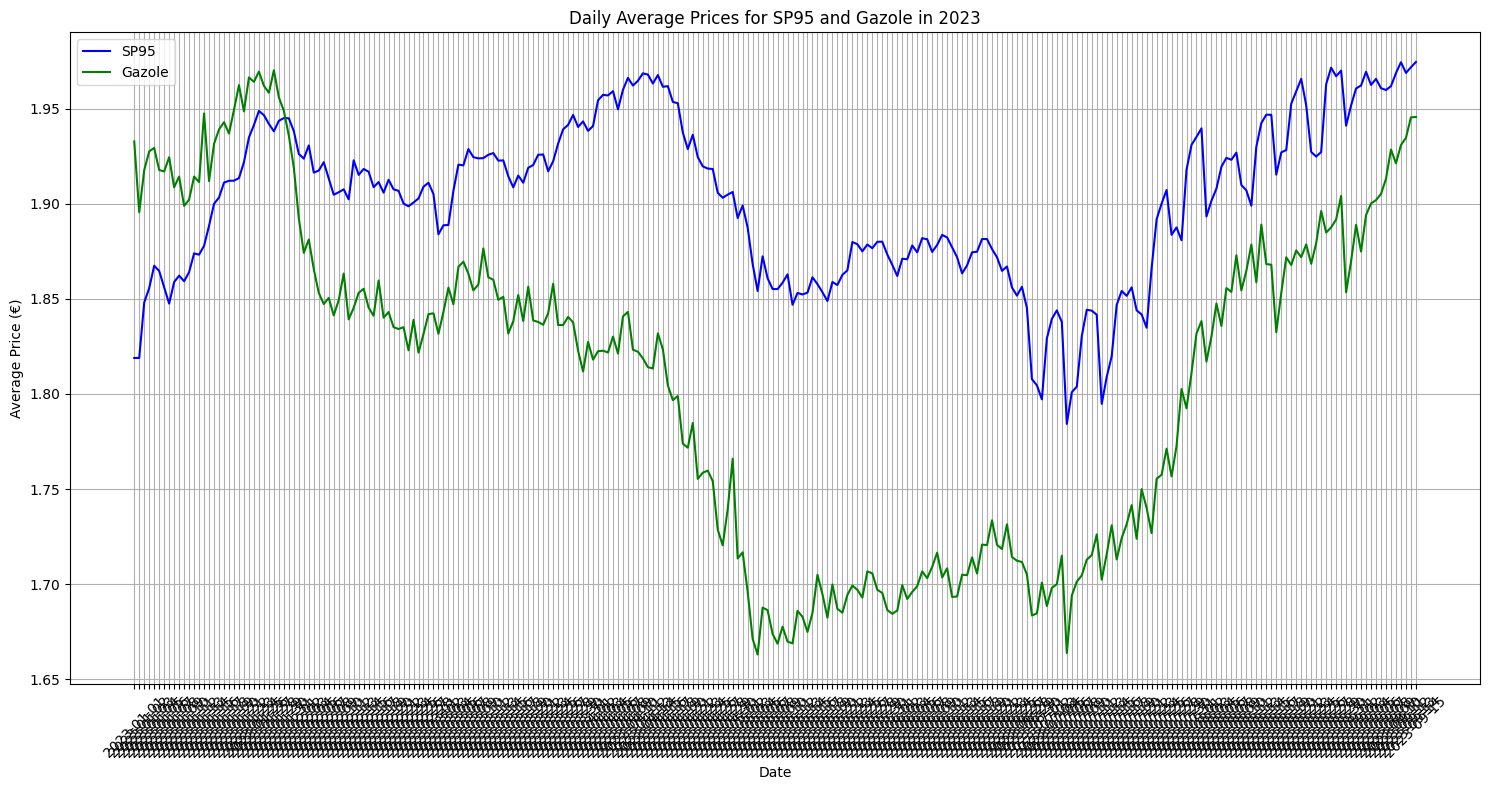

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the daily averages to pandas dataframes
df_SP95 = pd.DataFrame(list(daily_averages['SP95'].items()), columns=["Date", "SP95"]).sort_values(by="Date")
df_Gazole = pd.DataFrame(list(daily_averages['Gazole'].items()), columns=["Date", "Gazole"]).sort_values(by="Date")

# Merge the two dataframes on Date
df = df_SP95.merge(df_Gazole, on="Date")

# Plotting the daily averages
plt.figure(figsize=(15, 8))
plt.plot(df["Date"], df["SP95"], label="SP95", color="blue")
plt.plot(df["Date"], df["Gazole"], label="Gazole", color="green")
plt.xlabel("Date")
plt.ylabel("Average Price (€)")
plt.title("Daily Average Prices for SP95 and Gazole in 2023")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()